# In-situ precipitation assessment for drought monitoring 

Production date: 21/10/2024

Produced by: Ana Oliveira and João Paixão (CoLAB +ATLANTIC)

## 🌍 Use case: Adaptation do Climate Extremes.

## ❓ Quality assessment question
* **User Question: How well can we disclose which regions are the most exposed to droughts? What are the observed changes?**



In this Use Case, we will access the E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations (henceforth, E-OBS) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and analyse the E-OBS precipitation (RR) drought extremes, over a given Area of Interest (AoI), as a regional example of using E-OBS in the scope of the European State of Climate [[1]](https://climate.copernicus.eu/esotc/2023). The analysis includes drought indicators as defined by the World Meteorological Organization's Expert Team on Sector-Specific Climate Indices (ET-SCI) in conjunction with sector experts [[2]](https://climpact-sci.org/) [[3]](https://library.wmo.int/index.php?lvl=notice_display&id=20130):
- (i) Standardized Precipitation Index (SPI);
- (ii) Standardized Precipitation Evapotranspiration Index (SPEI); 
- (iii) the corresponding maps, to disclose where drought extremes are changing the most.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
- The E-OBS dataset offers a consistent and complete set of gridded meteorological observations over Europe suitable for analysing climate change and extremes, including for precipitation monitoring. [[4]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017JD028200)

- Its reliance on observation data indicates a more sensitive depiction of extreme values, being fit for drought monitoring. For example, according to [[5]](https://doi.org/10.1002/joc.7269) both E-OBS and ERA5 demonstrate accuracy in capturing precipitation patterns, with E-OBS showing good agreement in regions with dense station networks. The authors also concluded that E-OBS can capture extreme values of precipitation in areas with high data density but may smooth out extreme events in data-sparse regions.

- E-OBS is also proved as useful in monitoring drought conditions over the Iberian Peninsula, showing similar results to those reported in the literature over this region, using other observational gridded data [[7]](https://doi.org/10.1016/j.wace.2021.100320). Indeed, SPEI showcases more significant and pronounced trends over the region, and increased sensitivity in drought detection. Furthermore, results agree with the notion that the Iberian Peninsula is a hotspot for climate change impacts related to drought.

- In an another example, [[6]](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.6950) evaluated the effectiveness of the E-OBS dataset for drought monitoring in Greek wine production areas from 1981 to 2012. E-OBS excelled in reproducing annual decreasing precipitation trends across spring, summer, and autumn, and accurately captured monthly variability, especially in the spring and summer. It demonstrated lower error rates compared to other datasets and performed well in various statistical evaluations, including better simulation of wet and dry day probabilities and extreme precipitation indices. For drought monitoring specifically, E-OBS proved superior when using the Standardized Precipitation Index (SPI).
```

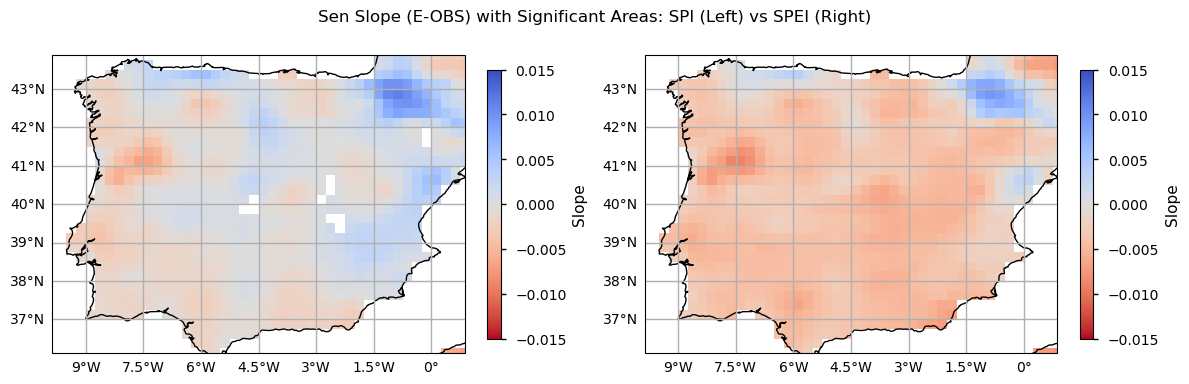

## 📋 Methodology

**[](code-section-1)**   
**[](code-section-2)**   
**[](code-section-3)**   
**[](code-section-4)**  
**[](code-section-5)**  
**[](code-section-6)**  

## 📈 Analysis and results

(code-section-1)=  
### 1. Define the AoI, search and download E-OBS

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import pymannkendall as mk
import math
import calendar
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import gamma, norm
from c3s_eqc_automatic_quality_control import download

plt.rcParams["figure.figsize"] = [15, 5]
plt.style.use("seaborn-v0_8-notebook")

#### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'in-situ observations' using the search bar. The data we need for this tutorial is the E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations. This catalogue entry provides a daily gridded dataset of historical meteorological observations, covering Europe (land-only), from 1950 to the present. This data is derived from in-situ meteorological stations, made available through the European Climate Assessment & Dataset (ECA&D) project, as provided by National Meteorological and Hydrological Services (NMHSs) and other data-holding institutes. 

E-OBS comprises a set of spatially continuous Essential Climate Variables (ECVs) from the Surface Atmosphere, following the Global Climate Observing System (GCOS) convention, provided as the mean and spread of the spatial prediction ensemble algorithm, at regular latitude-longitude grid intervals (at a 0.1° and 0.25° spatial resolution), and covering a long time-period, from 1 January 1950 to present-day. In addition to the land surface elevation, E-OBS includes daily air temperature (mean, maximum and minimum), precipitation amount, wind speed, sea-level pressure and shortwave downwelling radiation. 

The E-OBS version used for this Use Case, E-OBSv28.0e, was released in October 2023 and its main difference from the previous E-OBSv27.0e is the inclusion of new series and some corrections for precipitation stations.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use Case, the ensemble mean of precipitation (RR) will be used, considering the last version available (v28.0e). These can all be selected in the “Download data” tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

- Product Type: Ensemble mean  
- Variable: daily precipitation sum, and mean temperature
- Grid resolution: 0.25  
- Period: Full period  
- Version: 28.0e  
- Format: Zip file (.zip)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook …

Download data
… having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the `terms and conditions` of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the `Show API request` option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

### 1.1. Download and prepare E-OBS data

In [29]:
# Define region of interest - AoI
iberian_peninsula=[44, -10, 36, 1]

In [30]:
# Define request
request = (
    "insitu-gridded-observations-europe",
    {
        "format": "zip",
        "product_type": "ensemble_mean",
        "variable": ["mean_temperature","precipitation_amount"],
        "grid_resolution": "0_25deg",
        "period": "full_period",
        "version": "30_0e",
        "area": iberian_peninsula, #adjust for other regions
    },
)

# Process the request
data_EOBS = download.download_and_transform(*request)

100%|██████████| 1/1 [00:00<00:00, 81.67it/s]


### 1.2. Inspect and view data
Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray.Dataset.

To understand better the E-OBS data structure and check the aggregated Daily Mean Precipitation (RR) and the Daily Mean Temperature (TG), we will first need to retrieve the RR variable from the 2 multidimensional netCDF data structures and calculate the descriptive statistics.

In [31]:
# Subset data for the year range 1950 to 2020
start_date = '1950-01-01'; end_date = '2020-12-31'
data_EOBS = data_EOBS.sel(time=slice(start_date, end_date))

# Specify the new variable name, long name and units
new_long_name = 'Daily Precipitation'
new_units = 'mm'

# Change the variable long name
data_EOBS['rr'].attrs['long_name'] = new_long_name

# Specify the new variable units
data_EOBS['rr'].attrs['units'] = new_units

In [32]:
# Print the xarray data structure
data_EOBS

<xarray.Dataset> Size: 292MB
Dimensions:    (time: 25933, latitude: 32, longitude: 44)
Coordinates:
  * latitude   (latitude) float64 256B 36.12 36.38 36.62 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 352B -9.875 -9.625 -9.375 ... 0.625 0.875
  * time       (time) datetime64[ns] 207kB 1950-01-01 1950-01-02 ... 2020-12-31
Data variables:
    rr         (time, latitude, longitude) float32 146MB dask.array<chunksize=(13605, 16, 22), meta=np.ndarray>
    tg         (time, latitude, longitude) float32 146MB dask.array<chunksize=(13605, 16, 22), meta=np.ndarray>
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:51:50 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

We can see from the data structure that our information is already stored in a four-dimensional array with two data variables, corresponding to the RR 'mean' and TG 'mean', with dimensions: 25933 days in 'time', 32 steps in 'latitude', and 44 steps in 'longitude'. In this case, we are not using the toolbox's transformer function to calculate the maximum/minimum statistics directly from the daily data. The following 30-years climatological periods are considered, as per the guidelines from the World Meteorological Organization (WMO):

- 1951 to 1980
- 1961 to 1990
- 1971 to 2000
- 1981 to 2010
- 1991 to 2020

Let's inspect the data and compute these descriptive statistics of each period and print them in tabular form.

In [33]:
ds = data_EOBS

years_start = [1951, 1961, 1971, 1981, 1991]
years_stop = [1980, 1990, 2000, 2010, 2020]
periods = list(zip(years_start, years_stop))

# List to store the results as dictionaries for each row
table_data = []

# Loop through each period for the 'rr' variable
for start, stop in periods:
    # Select the data for each period
    period_data = ds['rr'].sel(time=slice(f"{start}-01-01", f"{stop}-12-31"))

    # Summary statistics: maximum and minimum
    mean = (period_data).mean(dim=['time', 'latitude', 'longitude']).compute()
    max_value = (period_data).max(dim=['time', 'latitude', 'longitude']).compute()
    min_value = (period_data).min(dim=['time', 'latitude', 'longitude']).compute()
    std = (period_data).std(dim=['time', 'latitude', 'longitude']).compute()
    n_observations = (period_data).count(dim=['time', 'latitude', 'longitude']).compute().item()

    # Append row data to the list
    table_data.append({
        'period': f"{start}-{stop}",
        'number': n_observations,
        'mean': mean.item(),
        'maximum': max_value.item(),
        'minimum': min_value.item(),
        'st.deviation': std.item()
    })

# Convert list of dictionaries to DataFrame for tabular display
summary_table = pd.DataFrame(table_data)

summary_table

,period,number,mean,maximum,minimum,st.deviation
0,1951-1980,10892252,1.750003,135.500000,0.0,4.383260
1,1961-1990,10891258,1.710895,147.699997,0.0,4.355820
2,1971-2000,10892252,1.649149,147.699997,0.0,4.281535
3,1981-2010,10891258,1.610303,147.699997,0.0,4.284586
4,1991-2020,10892252,1.619957,174.600006,0.0,4.376774


As we can see from the descriptive statistics, the two most recent climatological periods are characterized by mean lower precipitation - in the Iberian Peninsula, the annual daily mean RR between 1991 and 2020 is almost 0.15mm above the equivalent in 1951 to 1980. Nevertheless, when we check the annual daily maximum RR in each period, the most recent period shows a positive deviation of circa 40.0mm. To further explore these findings, let's compare also TG.


In [34]:
ds = data_EOBS

years_start = [1951, 1961, 1971, 1981, 1991]
years_stop = [1980, 1990, 2000, 2010, 2020]
periods = list(zip(years_start, years_stop))

# List to store the results as dictionaries for each row
table_data = []

# Loop through each period for the 'rr' variable
for start, stop in periods:
    # Select the data for each period
    period_data = ds['tg'].sel(time=slice(f"{start}-01-01", f"{stop}-12-31"))

    # Summary statistics: maximum and minimum
    mean = (period_data).mean(dim=['time', 'latitude', 'longitude']).compute()
    max_value = (period_data).max(dim=['time', 'latitude', 'longitude']).compute()
    min_value = (period_data).min(dim=['time', 'latitude', 'longitude']).compute()
    std = (period_data).std(dim=['time', 'latitude', 'longitude']).compute()
    n_observations = (period_data).count(dim=['time', 'latitude', 'longitude']).compute().item()

    # Append row data to the list
    table_data.append({
        'period': f"{start}-{stop}",
        'number': n_observations,
        'mean': mean.item(),
        'maximum': max_value.item(),
        'minimum': min_value.item(),
        'st.deviation': std.item()
    })

# Convert list of dictionaries to DataFrame for tabular display
summary_table = pd.DataFrame(table_data)

summary_table

,period,number,mean,maximum,minimum,st.deviation
0,1951-1980,10892252,13.030372,34.860001,-21.350000,6.920749
1,1961-1990,10891258,13.167892,35.380001,-19.090000,6.949373
2,1971-2000,10892252,13.348657,35.459999,-19.090000,6.910661
3,1981-2010,10891258,13.785862,36.259998,-19.090000,7.055634
4,1991-2020,10892252,14.076628,36.259998,-17.389999,7.108184


In the case of daily mean air temperature, the two most recent climatological periods are characterized by higher mean and maximum TG values - in the Iberian Peninsula, the annual daily mean TG between 1991 and 2020 is 1.0°C above the equivalent in 1951 to 1980, while the annual daily maximum increased circa 1.5°C. To further explore these findings, let's inspect the maps and time series of the data.


To do this, we need to create a set of weights based on latitude values. The weighted method is used to create a weighted dataset. Any subsequent aggregation operations (such as mean, sum, etc.) will take these weights into account. These weights can be used to account for the varying area of grid cells in latitude-longitude grids to ensure that calculations properly account for varying areas represented by grid cells at different latitudes.

Now we will proceed with plotting an example from the last time step of the time series to visualise the spatial level of detail of the data.

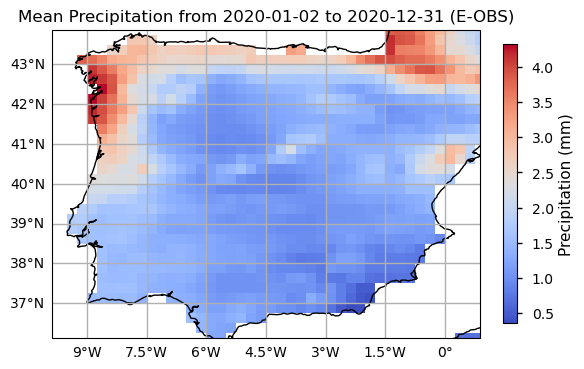

In [35]:
#Compute last years' mean
p_last_year = data_EOBS.isel(time=slice(-365,None))
p_last_year_mean = p_last_year.mean(['time'])

def plot_maps(da1, da2=None, **kwargs):
    # Set up the number of subplots depending on whether one or two datasets are passed
    if da2 is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        axes = [ax]
        datasets = [da1]
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        datasets = [da1, da2]
    
    for i, da in enumerate(datasets):
        # Get longitude and latitude extents
        lon_min, lon_max = np.min(da.longitude), np.max(da.longitude)
        lat_min, lat_max = np.min(da.latitude), np.max(da.latitude)

        # Plot using PlateCarree projection on the given axis
        facet = da.plot.pcolormesh(
            ax=axes[i],  # Use the current axis
            transform=ccrs.PlateCarree(),  # Coordinate transform for plotting
            **kwargs
        )

        # Set extent, add coastlines, and gridlines
        axes[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        axes[i].coastlines(lw=1)
        gl = axes[i].gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False

# Plot the selected time step
plot_maps(p_last_year_mean['rr'], cmap='coolwarm',
           cbar_kwargs={'label': 'Precipitation (mm)', 'fraction':0.03})

start_plot = pd.to_datetime(p_last_year.time.min().values).strftime('%Y-%m-%d')
end_plot = pd.to_datetime(p_last_year.time.max().values).strftime('%Y-%m-%d')
plt.title(f'Mean Precipitation from {start_plot} to {end_plot} (E-OBS)')
plt.show()

We will also plot the spatial weighted average of RR to check for its temporal variability in this area.

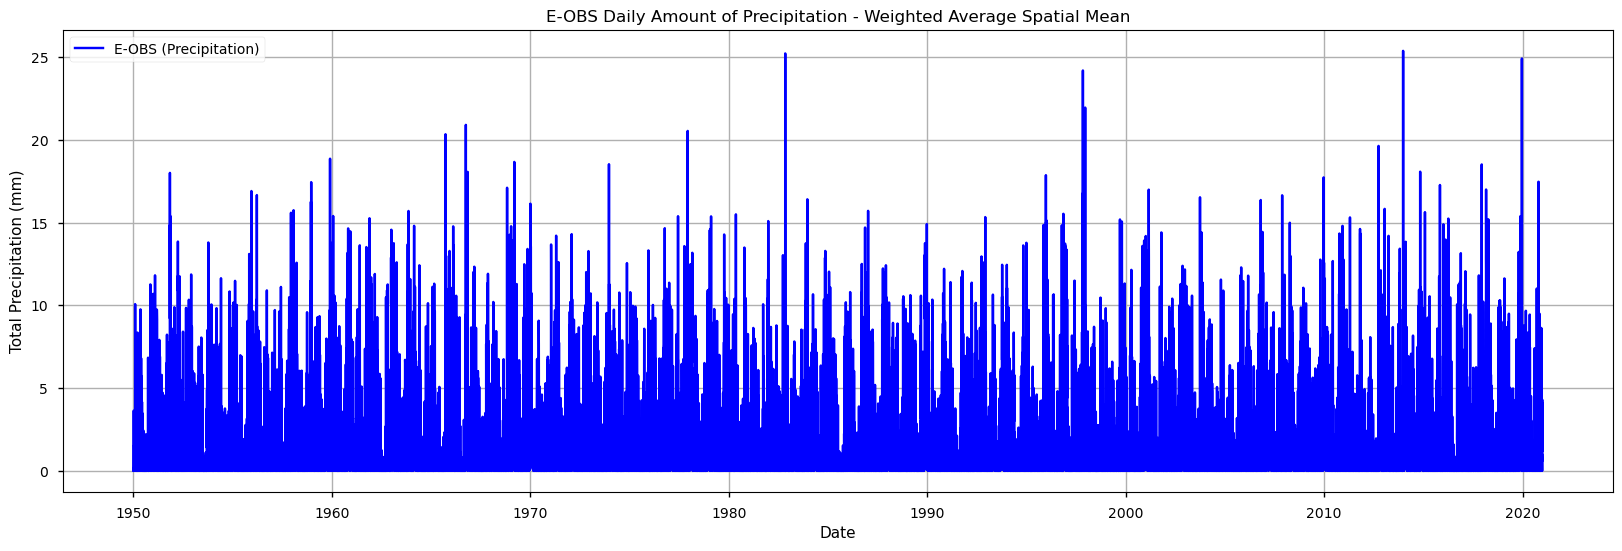

In [36]:
# Calculate the weighted mean of the time series
weights = np.cos(np.deg2rad(data_EOBS.latitude))
weights.name = "weights"

merged_p_weighted = data_EOBS['rr'].weighted(weights)
mean_p = merged_p_weighted.mean(("longitude", "latitude"))

# Plot the data
plt.figure(figsize=(20, 6))
plt.title('E-OBS Daily Amount of Precipitation - Weighted Average Spatial Mean')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (mm)')

# Plot prec data
plt.plot(mean_p.time, mean_p, label='E-OBS (Precipitation)', color='blue')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


These time series plots show that the E-OBS data product has very significative inter-annual variability in the RR values, with very few cases of RR surpassing 20mm. Some years with RR < 5mm are also apparent in the last decades. To move forward with the drought analysis, we will now calculate the two above-mentioned sector-specific drought indicators.

(code-section-2)=  
### 2. Calculate Standardized Precipitation Index (SPI)

The Standardized Precipitation Index (SPI) is commonly used to describe meteorological drought across various timescales. It correlates closely with soil moisture on shorter scales and with groundwater and reservoir levels on longer scales. The SPI allows for comparisons between different climatic regions by measuring observed precipitation as a standardized variation from a chosen probability distribution function that best fits the precipitation data. Typically, this data is adjusted to fit either a gamma or a Pearson Type III distribution before being converted into a normal distribution. The SPI values represent the number of standard deviations that the observed precipitation anomaly is from the long-term average. It can be calculated for periods ranging from 1 to 36 months using monthly data. Within the operational community, the SPI is recognized globally as the standard metric for assessing and reporting meteorological drought. An SPI below -2 corresponds to a precipitation deficit found in only 2.3% of cases (severe drought), while an SPI above 2 means excess rainfall in the top 2.3% of cases (extremely wet). Values between -1 and 1 occur around 68% of the time, reflecting near-normal conditions.

We will proceed to calculate SPI for 6-month periods.

In [37]:
# Define function to caluclate SPI
def calc_spi(precip):
    precip = np.array(precip)
    valid_data = precip[precip > 0]
    
    if len(valid_data) < 3:  # Ensure there are enough points to fit the distribution
        return np.full_like(precip, np.nan)
    
    shape, loc, scale = gamma.fit(valid_data, floc=0)
    gamma_dist = gamma(shape, loc=0, scale=scale)
    cdf = gamma_dist.cdf(precip)
    
    spi = norm.ppf(cdf)
    
    return spi

In [38]:
# Compute sum and resample the dataset to seasonal totals (e.g. 3 months, 6 months, 1 year), keeping spatial dimensions
time_scale = '6M'
annual_precip_EOBS = data_EOBS['rr'].resample(time=time_scale).sum()


# Apply the SPI function using apply_ufunc, preserving spatial dimensions
spi_values_EOBS = xr.apply_ufunc(
    calc_spi,
    annual_precip_EOBS,

    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
    output_dtypes=[float],
    keep_attrs=True
)

# Compute the results
spi_values_EOBS_compute = spi_values_EOBS.compute()

To inspect the SPI calculation results, we will first have a look at the time series over the Iberian Peninsula, highlighting the Moderate and Severe events detected.

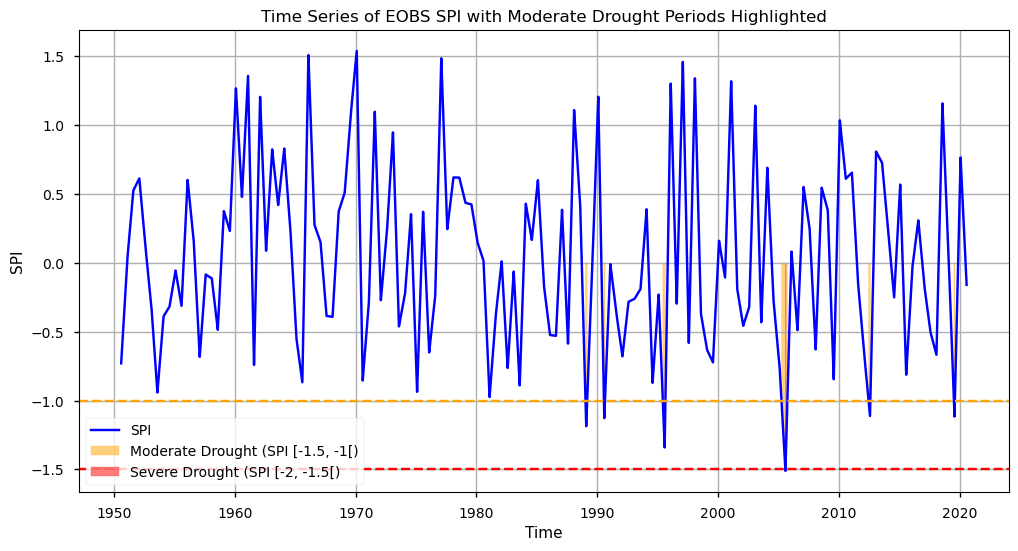

In [39]:
# Select the time period
start_date_plot_spi = '1950-01-01'
end_date_plot_spi = '2020-12-31'

# Reduce to mean SPI over spatial dimensions
spi_values_EOBS_weighted = spi_values_EOBS_compute.weighted(weights)
spi_mean_EOBS = spi_values_EOBS_weighted.mean(dim=['latitude', 'longitude'])

#select dates
spi_mean_EOBS = spi_mean_EOBS.sel(time= slice(start_date_plot_spi, end_date_plot_spi))

#interpolate to daily data for visualization
time = spi_mean_EOBS['time']
time = pd.date_range(time.min().values, time.max().values, freq='d')
spi_mean_EOBS = spi_mean_EOBS.interp(time=time)

# Find and print times where SPI indicates moderate drought (SPI < -1)
drought_periods = spi_mean_EOBS.where(spi_mean_EOBS < -1, drop=True)

# Convert the time coordinates to a pandas datetime index for better plotting
time = pd.to_datetime(time.values)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time, spi_mean_EOBS, label='SPI', color='b', linestyle='-')

# Highlight the drought periods using fill_between with appropriate mask
alpha=0.5 #transparency
plt.fill_between(time, spi_mean_EOBS, where=((spi_mean_EOBS < -1) & (spi_mean_EOBS > -1.5)),
                  color='orange', alpha=alpha, label='Moderate Drought (SPI [-1.5, -1[)')
plt.fill_between(time, spi_mean_EOBS, where=(spi_mean_EOBS < -1.5),
                  color='r', alpha=alpha, label='Severe Drought (SPI [-2, -1.5[)')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('SPI')
plt.title('Time Series of E-OBS SPI with Moderate Drought Periods Highlighted')
plt.axhline(y=-1.5, color='r', linestyle='--')
plt.axhline(y=-1, color='orange', linestyle='--')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

As we can see from this plot, SPI shows a tendency towards lower values in the last two decades. In particular, we observe 5 instances of Moderate drought since 1985, and 1 Severe Drought event after 2005, agreeing with the overall notion that drought events are already becoming more frequent, and severe, recently. These findings agree with those reported in the literature [[7]](https://doi.org/10.1016/j.wace.2021.100320).

(code-section-3)=  
### 3. Calculate Standardized Precipitation Evapotranspiration Index (SPEI)

Extending the above-calculated SPI, the Standardized Precipitation Evapotranspiration Index (SPEI) adds additional information by incorporating temperature data to account for both precipitation and evapotranspiration (ET), making it sensitive to climate-driven changes in water demand. This allows SPEI to better reflect drought conditions under warming scenarios, as it considers not only rainfall deficits but also increased evaporation due to higher temperatures. While several ET estimation algorithm exist, here we use the Thornthwaite method, which is based on temperature and solar radiation, by latitude and season. The interpretation of SPEI values is similar to SPI in terms of probabilistic distribution, where values follow a standard normal distribution. The functions for Evapotranspiration computation were based on the *"climate_indices"* Python library, from James Adams [[8]](https://github.com/monocongo/climate_indices).

In [40]:
# To define the month-days, we simplify by only using non leap year's month-days
_MONTH_DAYS_NONLEAP = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# Angle values used within the _sunset_hour_angle() function defined below
# Valid range for latitude, in radians
_LATITUDE_RADIANS_MIN = np.deg2rad(-90.0)
_LATITUDE_RADIANS_MAX = np.deg2rad(90.0)

# Valid range for solar declination angle, in radians
_SOLAR_DECLINATION_RADIANS_MIN = np.deg2rad(-23.45)
_SOLAR_DECLINATION_RADIANS_MAX = np.deg2rad(23.45)

In [41]:
# Define usefull functions to compute the evapotranspiration
def _sunset_hour_angle(latitude_radians: float, solar_declination_radians: float,) -> float:

    # validate the latitude argument
    if not _LATITUDE_RADIANS_MIN <= latitude_radians <= _LATITUDE_RADIANS_MAX:
        raise ValueError(
            "latitude outside valid range [{0!r} to {1!r}]: {2!r}".format(
                _LATITUDE_RADIANS_MIN, _LATITUDE_RADIANS_MAX, latitude_radians
            )
        )

    # validate the solar declination angle argument
    if not _SOLAR_DECLINATION_RADIANS_MIN <= solar_declination_radians <= _SOLAR_DECLINATION_RADIANS_MAX:
        raise ValueError(
            f"solar declination angle outside the valid range [{str(_SOLAR_DECLINATION_RADIANS_MIN)}\
                  to {str(_SOLAR_DECLINATION_RADIANS_MAX)}]: {str(solar_declination_radians)} (actual value)"
        )

    # calculate the cosine of the sunset hour angle (*Ws* in FAO 25)
    # from latitude and solar declination
    cos_sunset_hour_angle = -math.tan(latitude_radians) * math.tan(solar_declination_radians)

    # If the sunset hour angle is >= 1 there is no sunset, i.e. 24 hours of daylight
    # If the sunset hour angle is <= 1 there is no sunrise, i.e. 24 hours of darkness
    return math.acos(min(max(cos_sunset_hour_angle, -1.0), 1.0))

def _solar_declination(
    day_of_year: int,
) -> float:
    if not 1 <= day_of_year <= 366:
        raise ValueError("Day of the year must be in the range [1-366]: " "{0!r}".format(day_of_year))

    return 0.409 * math.sin(((2.0 * math.pi / 365.0) * day_of_year - 1.39))

def _daylight_hours(sunset_hour_angle_radians: float,) -> float:
    if not 0.0 <= sunset_hour_angle_radians <= math.pi:
        raise ValueError( f"sunset hour angle outside valid range [0.0 to \
                         {str(math.pi)}] : {str(sunset_hour_angle_radians)} (actual value)"
        )

    # calculate daylight hours from the sunset hour angle
    return (24.0 / math.pi) * sunset_hour_angle_radians

def _monthly_mean_daylight_hours(latitude_radians: float,) -> np.ndarray:

    # allocate an array of daylight hours for each of the 12 months of the year
    monthly_mean_dlh = np.zeros((12,))

    # keep a count of the day of the year
    day_of_year = 1

    # loop over each calendar month to calculate the daylight hours for the month
    for i, days_in_month in enumerate(_MONTH_DAYS_NONLEAP):
        cumulative_daylight_hours = 0.0  # cumulative daylight hours for the month
        for _ in range(1, days_in_month + 1):
            daily_solar_declination = _solar_declination(day_of_year)
            daily_sunset_hour_angle = _sunset_hour_angle(latitude_radians, daily_solar_declination)
            cumulative_daylight_hours += _daylight_hours(daily_sunset_hour_angle)
            day_of_year += 1

        # calculate the mean daylight hours of the month
        monthly_mean_dlh[i] = cumulative_daylight_hours / days_in_month

    return monthly_mean_dlh

def pet_thornthwaite(mean_monthly_temps, latitude_map_degrees):
    if np.isnan(mean_monthly_temps).any():
        return np.zeros(12)

    #print(mean_monthly_temps[0], latitude_degrees[0])
    # Ensure the array is writable by creating a copy
    mean_monthly_temps = np.copy(mean_monthly_temps)

    mean_monthly_temps[mean_monthly_temps < 0] = 0.0

    heat_index = np.sum(np.power(mean_monthly_temps / 5.0, 1.514))
    a = (6.75e-07 * heat_index**3) - (7.71e-05 * heat_index**2) + (1.792e-02 * heat_index) + 0.49239

    if len(np.unique(latitude_map_degrees)) == 1:
        latitude_radians = np.radians(latitude_map_degrees[0])
    else: print('Latitudes must be all the same in this mapping structure')

    mean_daylight_hours = np.array(_monthly_mean_daylight_hours(latitude_radians))
    adjust = (mean_daylight_hours / 12.0) * (_MONTH_DAYS_NONLEAP / 30.0)

    # calculate the Thornthwaite equation
    pet = np.full(mean_monthly_temps.shape, np.nan)
    pet = 16*adjust*((10*mean_monthly_temps/heat_index)**a)

    return pet

In [42]:
# t_EOBS_mean = data_EOBS.drop_vars('rr').resample(time='M').mean()
# Resample daily temperature to montly mean for evapotranspiration computation
t_EOBS_mean = data_EOBS.drop_vars('rr').resample(time='M').mean()

Considering the amount of data, for faster computation, we must parallelise the pixel wise calculation of PET. For this, we create a latitude mapping - i.e., we save latitude in a xr.DataArray with the same structure as "t_EOBS_mean" for a later use.

In [43]:
# Make a copy of the original dataset
latitude_matrix = t_EOBS_mean.copy()

# Helper function to replace temperature values with the corresponding latitude
def replace_with_latitude(temp_array, latitudes):
    # This function will broadcast latitude values across the temperature data
    return np.broadcast_to(latitudes[:, np.newaxis], temp_array.shape)

# Apply the function across the dataset using apply_ufunc
latitude_matrix['tg'] = xr.apply_ufunc(
    replace_with_latitude,                   # Function to apply
    t_EOBS_mean['tg'],                       # Temperature values
    t_EOBS_mean.coords['latitude'],          # Latitude values
    input_core_dims=[['latitude', 'longitude'], ['latitude']],  # Dimensions in function
    output_core_dims=[['latitude', 'longitude']],  # Output dimensions
    vectorize=True,                          # Vectorization for efficiency
    dask='parallelized',                     # Parallelize if using Dask
    output_dtypes=[float],                    # Specify output dtype
    dask_gufunc_kwargs={'allow_rechunk': True}  # Allow rechunking
)

# Compute the result if using Dask for parallelism
latitude_matrix['tg'] = latitude_matrix['tg'].compute()

In [44]:
# Rename variables to merge E-OBS precipitation and temperature again
latitude_matrix=latitude_matrix.rename({'tg':'lats'})
ds_monthly = xr.merge([t_EOBS_mean, latitude_matrix], join='left')

In [45]:
# Helper function to apply Thornthwaite method by grouping by year and month
def apply_thornthwaite(group):
    # Group data by year and month, then apply the Thornthwaite method
    temp = group['tg']
    lats = group['lats']
    
    # Call the Thornthwaite function
    et_func = xr.apply_ufunc(
        pet_thornthwaite,
        temp,
        lats,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        dask_gufunc_kwargs={'allow_rechunk': True},
        output_dtypes=[float],
        keep_attrs=True
        )

    # Compute the results
    et = et_func.compute()

    return et

# Apply Thornthwaite grouped by year and month
et_monthly = ds_monthly.groupby('time.year').map(apply_thornthwaite)
et_monthly = et_monthly.rename('et')

Having calculated ET, we can now plot the last time step of the data to visualise the spatial structure of SPEI.

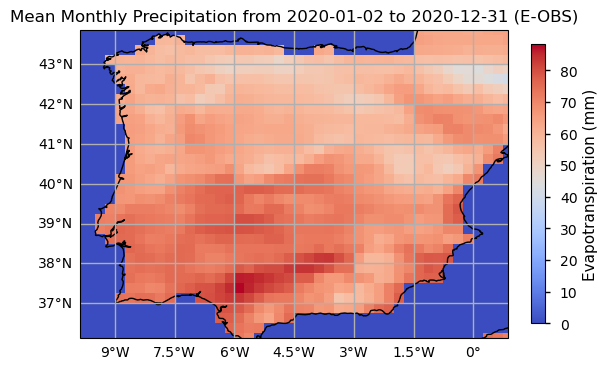

In [46]:
# Selecting the last year of the series as an example
et_last_year = et_monthly.isel(time=slice(-12,None))
et_last_year_mean = et_last_year.mean(['time'])

# Plot the selected time step
plot_maps(et_last_year_mean, cmap='coolwarm',
           cbar_kwargs={'label': 'Evapotranspiration (mm)', 'fraction':0.03})

start_plot = pd.to_datetime(p_last_year.time.min().values).strftime('%Y-%m-%d')
end_plot = pd.to_datetime(p_last_year.time.max().values).strftime('%Y-%m-%d')
plt.title(f'Mean Monthly Precipitation from {start_plot} to {end_plot} (E-OBS)')
plt.show()

As with SPI, also the SPEI index requires the definition of the time scale for aggregating the variables and calculate its values as seasonal or annual summaries (e.g., 3 months, 6 months, 1 year). Here, we selected 6 months as the target time scale, and proceed to calculate the precipitation and evapotranspiration sums over this period. We will inspect the resulting time series.

In [47]:
# Compute sum and resample the dataset to seasonal totals (e.g. 3 months, 6 months, 1 year), keeping spatial dimensions
time_scale = '6M'

precip_EOBS = data_EOBS['rr'].resample(time=time_scale).sum()
et_EOBS = et_monthly.resample(time=time_scale).sum()

In [48]:
# Helper functions to calculate SPEI
def calc_spei(precip):

    count_nonzero_non_nan = np.sum((precip != 0) & ~np.isnan(precip))
    if count_nonzero_non_nan < 3:
        return np.full_like(precip, np.nan)

    precip = np.array(precip)

    shape, loc, scale = gamma.fit(precip)
    gamma_dist = gamma(shape, loc=loc, scale=scale)
    cdf = gamma_dist.cdf(precip)
    
    spi = norm.ppf(cdf)
    
    return spi

# Apply the SPI function using apply_ufunc, preserving spatial dimensions
spi_values_EOBS = xr.apply_ufunc(
    calc_spei,
    precip_EOBS-et_EOBS,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
    output_dtypes=[float],
    keep_attrs=True
)

# Compute the results
spei_values_EOBS_compute = spi_values_EOBS.compute()

As with SPI, we will also plot the SPEI time series over the Iberian Peninsula, highlighting the Moderate and Severe events detected.

In [49]:
start_date_plot_spei = '1950-01-01'
end_date_plot_spei = '2020-12-31'

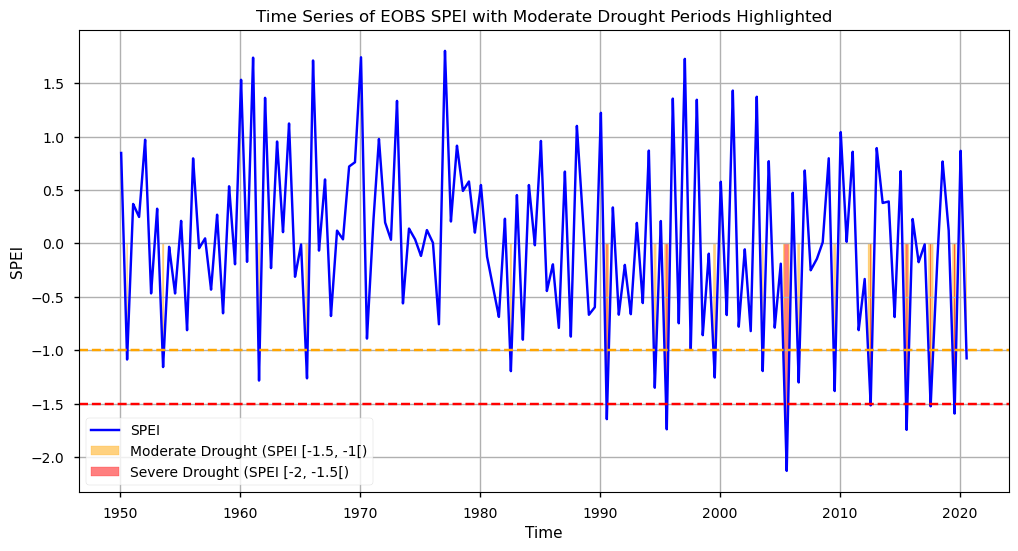

In [50]:
# Reduce to mean SPI over spatial dimensions (weighted latitude)
spei_EOBS_weighted = spei_values_EOBS_compute.weighted(weights)
spei_mean_EOBS = spei_EOBS_weighted.mean(dim=['latitude', 'longitude'])

#select dates
spei_mean_EOBS = spei_mean_EOBS.sel(time= slice(start_date_plot_spei, end_date_plot_spei))

#interpolate to daily data for visualization
time = spei_mean_EOBS['time']
time = pd.date_range(time.min().values, time.max().values, freq='d')
spei_mean_EOBS = spei_mean_EOBS.interp(time=time)

# Find and print times where SPI indicates moderate droughst (SPI < -1)
drought_periods = spei_mean_EOBS.where(spei_mean_EOBS < -1, drop=True)

# Convert the time coordinates to a pandas datetime index for better plotting
time = pd.to_datetime(time.values)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time, spei_mean_EOBS, label='SPEI', color='b', linestyle='-')

# Highlight the drought periods using fill_between with appropriate mask
alpha=0.5 #transparency
plt.fill_between(time, spei_mean_EOBS, where=((spei_mean_EOBS < -1) & (spei_mean_EOBS > -1.5)),
                  color='orange', alpha=alpha, label='Moderate Drought (SPEI [-1.5, -1[)')
plt.fill_between(time, spei_mean_EOBS, where=(spei_mean_EOBS < -1.5),
                  color='r', alpha=alpha, label='Severe Drought (SPEI [-2, -1.5[)')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('SPEI')
plt.title('Time Series of E-OBS SPEI with Moderate Drought Periods Highlighted')
plt.axhline(y=-1.5, color='r', linestyle='--')
plt.axhline(y=-1, color='orange', linestyle='--')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

 As we can see from this plot, SPEI also shows a tendency towards lower values in the last two decades. However, this index shows a higher frequency of severe drought periods. This is due to the evapotranspiration factor, providing a more sensitive assessment of the severity and impact of low precipitation periods. In particular, we observe 17 instances of Moderate drought since 1980, and 7 Severe Drought events after 1990. These findings  also agree with findings reported in the literature [[7]](https://doi.org/10.1016/j.wace.2021.100320).

(code-section-4)=  
### 4. Comparing SPI and SPEI Climatologies
To further compare the E-OBS SPI and SPEI calculated results, let's analyse the spatial patterns of their climatologies. With the subsets per period already selected, now it is time to calculate the climatological mean over each Time of Interest (ToI). Here, we calculate the pixel-wise annual mean SPI and SPEI values.

In [62]:
# Define the periods
periods = [
    ('1951-01-01', '1980-12-31'),
    ('1961-01-01', '1990-12-31'),
    ('1971-01-01', '2000-12-31'),
    ('1981-01-01', '2010-12-31'),
    ('1991-01-01', '2020-12-31')
]

# Helper function to plot the climatology maps
def compute_climatology(data):
    # Calculate the mean data for each period
    mean_data_clim = []
    for start, end in periods:
        mean_data = data.sel(time=slice(start, end)).mean(dim='time')
        mean_data_clim.append(mean_data)
    return mean_data_clim

def plot_climatology(data, subtitle='Mean Precipitation', cb_label='Precipitation (mm)', **kwargs):
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(periods), figsize=(24, 5), subplot_kw={"projection": ccrs.PlateCarree()})

    # Plot each clim
    for i, (ax, subdata, (start, end)) in enumerate(zip(axes, data, periods)):
        lon_min, lon_max = np.min(subdata.longitude), np.max(subdata.longitude)
        lat_min, lat_max = np.min(subdata.latitude), np.max(subdata.latitude)

        facet = subdata.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap='viridis',  # You can change the colormap
            add_colorbar=False,  # Disable the colorbar for now, we will add it later
            **kwargs
        )

        # Set extent, add coastlines, and gridlines
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.coastlines(lw=1)
        gl = ax.gridlines(draw_labels=True)

        if i == 0: gl.left_labels = True
        else: gl.left_labels = False
        gl.top_labels = gl.right_labels = False
        
        # Title for each subplot
        ax.set_title(f'{subtitle} {start[:4]}-{end[:4]}')

    plt.subplots_adjust(wspace=0.05)#, right=0.85) 

    cbar_ax = fig.add_axes([0.91, 0.23, 0.01, 0.53])  # Adjust the position as needed
    cbar = fig.colorbar(facet, cax=cbar_ax, orientation='vertical')
    cbar.set_label(cb_label)

    # Show the plot
    #plt.tight_layout()
    plt.show()

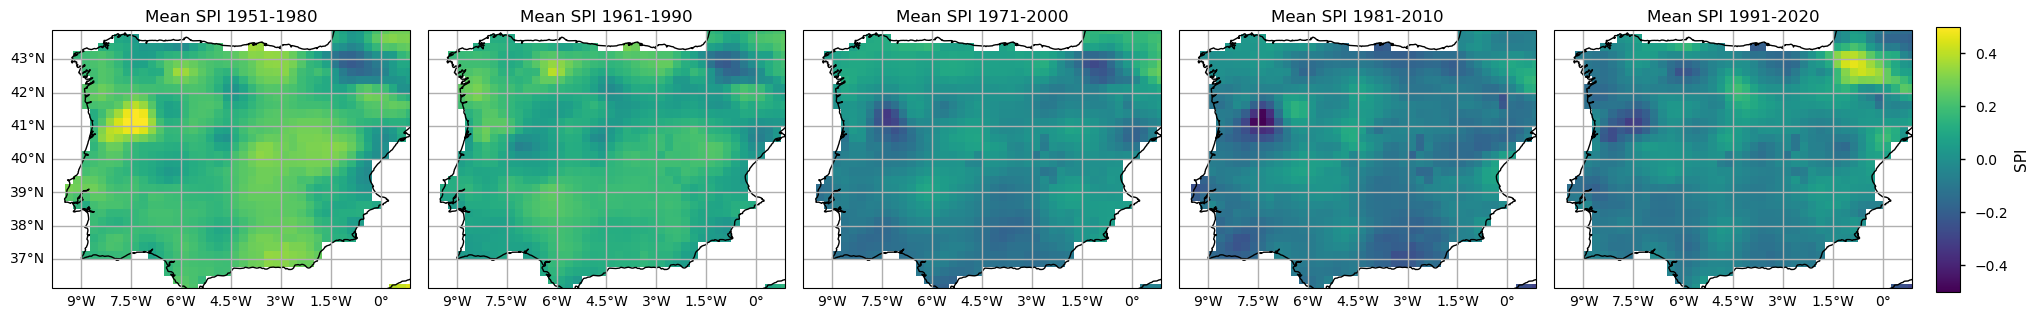

In [52]:
# Plotting SPI
mean_spi = compute_climatology(spi_values_EOBS_compute)
plot_climatology(mean_spi, subtitle='Mean SPI', cb_label='SPI', vmax=0.5, vmin=-0.5)

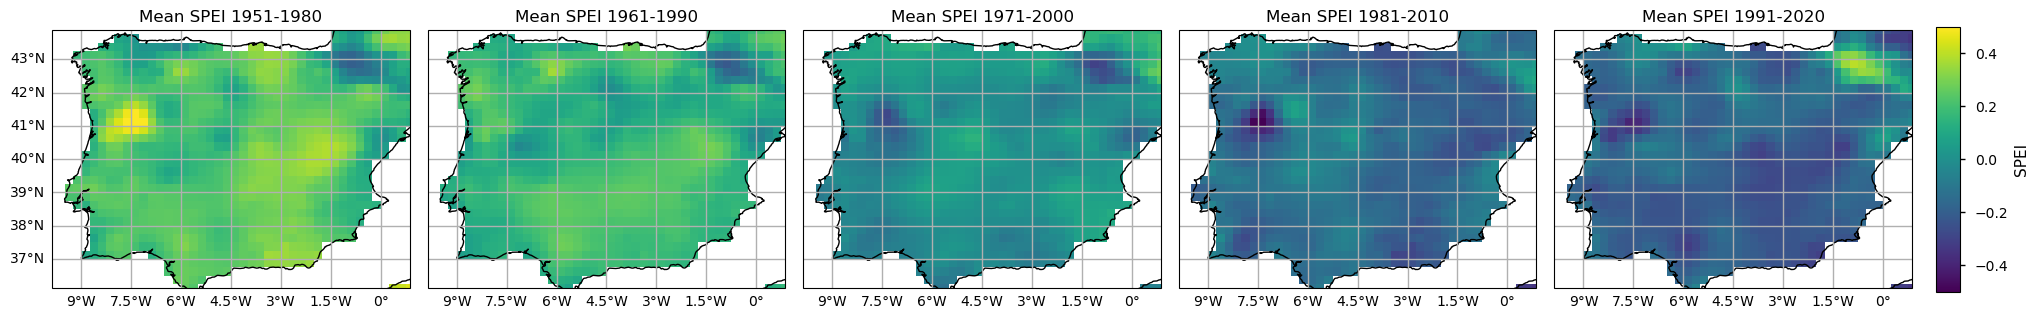

In [53]:
# Plotting SPEI
mean_spei = compute_climatology(spei_values_EOBS_compute)
plot_climatology(mean_spei, subtitle='Mean SPEI', cb_label='SPEI', vmax=0.5, vmin=-0.5)

From both the SPI and SPEI plots, we observe a noticeable decline in these indices over time across most of the region, indicating an increase in dry conditions. The spatial pattern is also consistent - on average, both indices denote drier conditions in southern and inland locations of the Iberian Peninsula, since 1981. The temporal distribution in these plots shows that higher SPI and SPEI values representing wetter conditions are more frequent in earlier climatology periods (1951-1980 and 1961-1990), while lower values, indicative of drought, are reached in the two most recent periods (1981-2010 and 1991-2020). These maps highlight the tendency for drier conditions. The most notorious SPI/SPEI decrease is in the North east of Portugal. On the contrary, the Pyrenees area shows an actual increase of SPI/SPEI, so wetter conditions are more frequent in the past 30 years.

In [54]:
start_clim1 = '1960-01-01'; end_clim1 = '1989-12-31'
start_clim2 = '1990-01-01'; end_clim2 = '2020-12-31'

SPEI_climatology1 = spei_values_EOBS_compute.sel(time=slice(start_clim1, end_clim1)).mean(dim=['time'])
SPEI_climatology2 = spei_values_EOBS_compute.sel(time=slice(start_clim2, end_clim2)).mean(dim=['time'])

(code-section-5)=  
### 5. Calculate Linear Trends

To quantify drought changes over the Iberian Peninsula we will now use the Mann-Kendall test to assess the presence of a statistically significant monotonic trend over time. Additionally, the Sen Slope estimator will be applied to quantify the magnitude of the trend, providing an estimate of the rate of change. We will calculate these trend parameters for SPI and SPEI over this area, considering both the frequency of dry days and the magnitude of both indices (average and minimum). 

In [67]:
# Helper function to apply Mann-Kendall and Sen's Slope for a specifi column of a dataframe df
def apply_mk_sen(df, column):
    np.float = np.float64
    mk_result = mk.original_test(df[column])
    sen_slope = mk.sens_slope(df[column]).slope
    return mk_result, sen_slope

# Calculate the adjusted intercept - this is for visualization purposes
def calculate_adjusted_intercept(intercept, slope, start_year):
    return intercept - slope * start_year

def show_mk_sen_results(df1, df2, name1='P_EOBS_1', name2='P_EOBS_2', min=False):
    """
    This function applies the Mann-Kendall and Sen Slope tests for two datasets and plots results side by side.
    df1, df2 -> DataFrames for the two datasets
    name1, name2 -> Names for variables in df1 and df2
    min -> Boolean to specify whether to calculate minimum or maximum for stats
    """

    def process_df(df, name, min):
        maxmin = 'Min' if min else 'Max'
        
        count_name = f'Count_{name}'
        mean_name = f'Mean_{name}'
        maxmin_name = f'{maxmin}_{name}'

        # Apply the Mann-Kendall and Sen's Slope tests
        mk_count, sen_slope_count = apply_mk_sen(df, count_name)
        mk_mean, sen_slope_mean = apply_mk_sen(df, mean_name)
        mk_maxmin, sen_slope_maxmin = apply_mk_sen(df, maxmin_name)

        # Adjust intercept for the year range
        start_year = df['Year'].min()
        adjusted_intercept_count = calculate_adjusted_intercept(mk_count.intercept, sen_slope_count, start_year)
        adjusted_intercept_mean = calculate_adjusted_intercept(mk_mean.intercept, sen_slope_mean, start_year)
        adjusted_intercept_max = calculate_adjusted_intercept(mk_maxmin.intercept, sen_slope_maxmin, start_year)

        return (mk_count, sen_slope_count, adjusted_intercept_count,
                mk_mean, sen_slope_mean, adjusted_intercept_mean,
                mk_maxmin, sen_slope_maxmin, adjusted_intercept_max,
                count_name, mean_name, maxmin_name, maxmin)

    # Process both dataframes
    results1 = process_df(df1, name1, min)
    results2 = process_df(df2, name2, min)

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

    def plot_results(df, results, ax_col):
        (mk_count, sen_slope_count, adjusted_intercept_count,
         mk_mean, sen_slope_mean, adjusted_intercept_mean,
         mk_maxmin, sen_slope_maxmin, adjusted_intercept_max,
         count_name, mean_name, maxmin_name, maxmin) = results

        # Plot 'Count' variable
        axs[0, ax_col].bar(df['Year'], df[count_name], label='Count', color='black')
        axs[0, ax_col].plot(df['Year'], sen_slope_count * df['Year'] + adjusted_intercept_count,
                            label="Sen's Slope", linestyle='--', color='red')
        axs[0, ax_col].set_title(f'{count_name} with MK and Sen\'s Slope')
        axs[0, ax_col].set_xlabel('Year')
        axs[0, ax_col].set_ylabel(f'Count {count_name}')
        axs[0, ax_col].legend(loc='upper right')
        axs[0, ax_col].text(0.05, 0.95, f"Slope: {sen_slope_count:.3f} dry days/year\nP-value: {mk_count.p:.3f}\nTau: {mk_count.Tau:.3f}\nIntercept: {mk_count.intercept:.3f} Events",
                            transform=axs[0, ax_col].transAxes, verticalalignment='top', color='red')

        # Plot 'Mean'
        axs[1, ax_col].plot(df['Year'], df[mean_name], label='Mean', color='black')
        axs[1, ax_col].plot(df['Year'], sen_slope_mean * df['Year'] + adjusted_intercept_mean,
                            label="Sen's Slope", linestyle='--', color='red')
        axs[1, ax_col].set_title(f'{mean_name} with MK and Sen\'s Slope')
        axs[1, ax_col].set_xlabel('Year')
        axs[1, ax_col].set_ylabel(f'{mean_name}')
        axs[1, ax_col].legend(loc='upper right')
        axs[1, ax_col].text(0.05, 0.95, f"Slope: {sen_slope_mean:.3f} idx/year\nP-value: {mk_mean.p:.3f}\nTau: {mk_mean.Tau:.3f}\nIntercept: {mk_mean.intercept:.3f} idx",
                            transform=axs[1, ax_col].transAxes, verticalalignment='top', color='red')

        # Plot 'Max/Min'
        axs[2, ax_col].plot(df['Year'], df[maxmin_name], label=f'{maxmin}', color='black')
        axs[2, ax_col].plot(df['Year'], sen_slope_maxmin * df['Year'] + adjusted_intercept_max,
                            label="Sen's Slope", linestyle='--', color='red')
        axs[2, ax_col].set_title(f'{maxmin_name} with MK and Sen\'s Slope')
        axs[2, ax_col].set_xlabel('Year')
        axs[2, ax_col].set_ylabel(f'{maxmin_name}')
        axs[2, ax_col].legend(loc='upper right')
        axs[2, ax_col].text(0.05, 0.95, f"Slope: {sen_slope_maxmin:.3f} idx/year\nP-value: {mk_maxmin.p:.3f}\nTau: {mk_maxmin.Tau:.3f}\nIntercept: {mk_maxmin.intercept:.3f} idx",
                            transform=axs[2, ax_col].transAxes, verticalalignment='top', color='red')

    # Plot results for both datasets side by side
    plot_results(df1, results1, 0)
    plot_results(df2, results2, 1)

    # Adjust layout
    plt.tight_layout()
    plt.show()

To use the Mann-Kendall method on drought frequency, we discretize the SPI/SPEI values by creating "dry_events". We chose a threshold of -0.5 (and below) to create a singular dry event day (pixel wise and per timestep). This threshold grants a minimum statistical significance of number of events. You can experiment with this value, possibly to evaluate the more extreme dry conditions (e.g. -1 or below). 

In [68]:
# chosen SPI/SPEI maximum value for a drier event. Change this value to analyse different intervals, which will result in less or more total events.
dryindex_threshold=-0.5

df_spi = pd.DataFrame({
    'Date': spi_mean_EOBS['time'].values,
    'Year': spi_mean_EOBS['time'].dt.year.values,
    'daily_weighted': spi_mean_EOBS.values,
    'dry_events': spi_mean_EOBS.where(spi_mean_EOBS <= -0.5, np.nan).values
})

# Group by year to calculate the required statistics
df_spi_events_stats = df_spi.groupby('Year').agg(
    Count_spi=('dry_events', 'count'),
    Mean_spi=('daily_weighted', 'mean'),
    Min_spi=('daily_weighted', 'min')
).reset_index()

df_spei = pd.DataFrame({
    'Date': spei_mean_EOBS['time'].values,
    'Year': spei_mean_EOBS['time'].dt.year.values,
    'daily_weighted': spei_mean_EOBS.values,
    'dry_events': spei_mean_EOBS.where(spei_mean_EOBS <= -0.5, np.nan).values
})

# Group by year to calculate the required statistics
df_spei_events_stats = df_spei.groupby('Year').agg(
    Count_spei=('dry_events', 'count'),
    Mean_spei=('daily_weighted', 'mean'),
    Min_spei=('daily_weighted', 'min')
).reset_index()

df_spei_events_stats.head()

,Year,Count_spei,Mean_spei,Min_spei
0,1950,129,-0.283698,-1.087246
1,1951,0,0.404486,0.131531
2,1952,0,0.143075,-0.468173
3,1953,188,-0.474460,-1.157757
4,1954,0,-0.212683,-0.468797


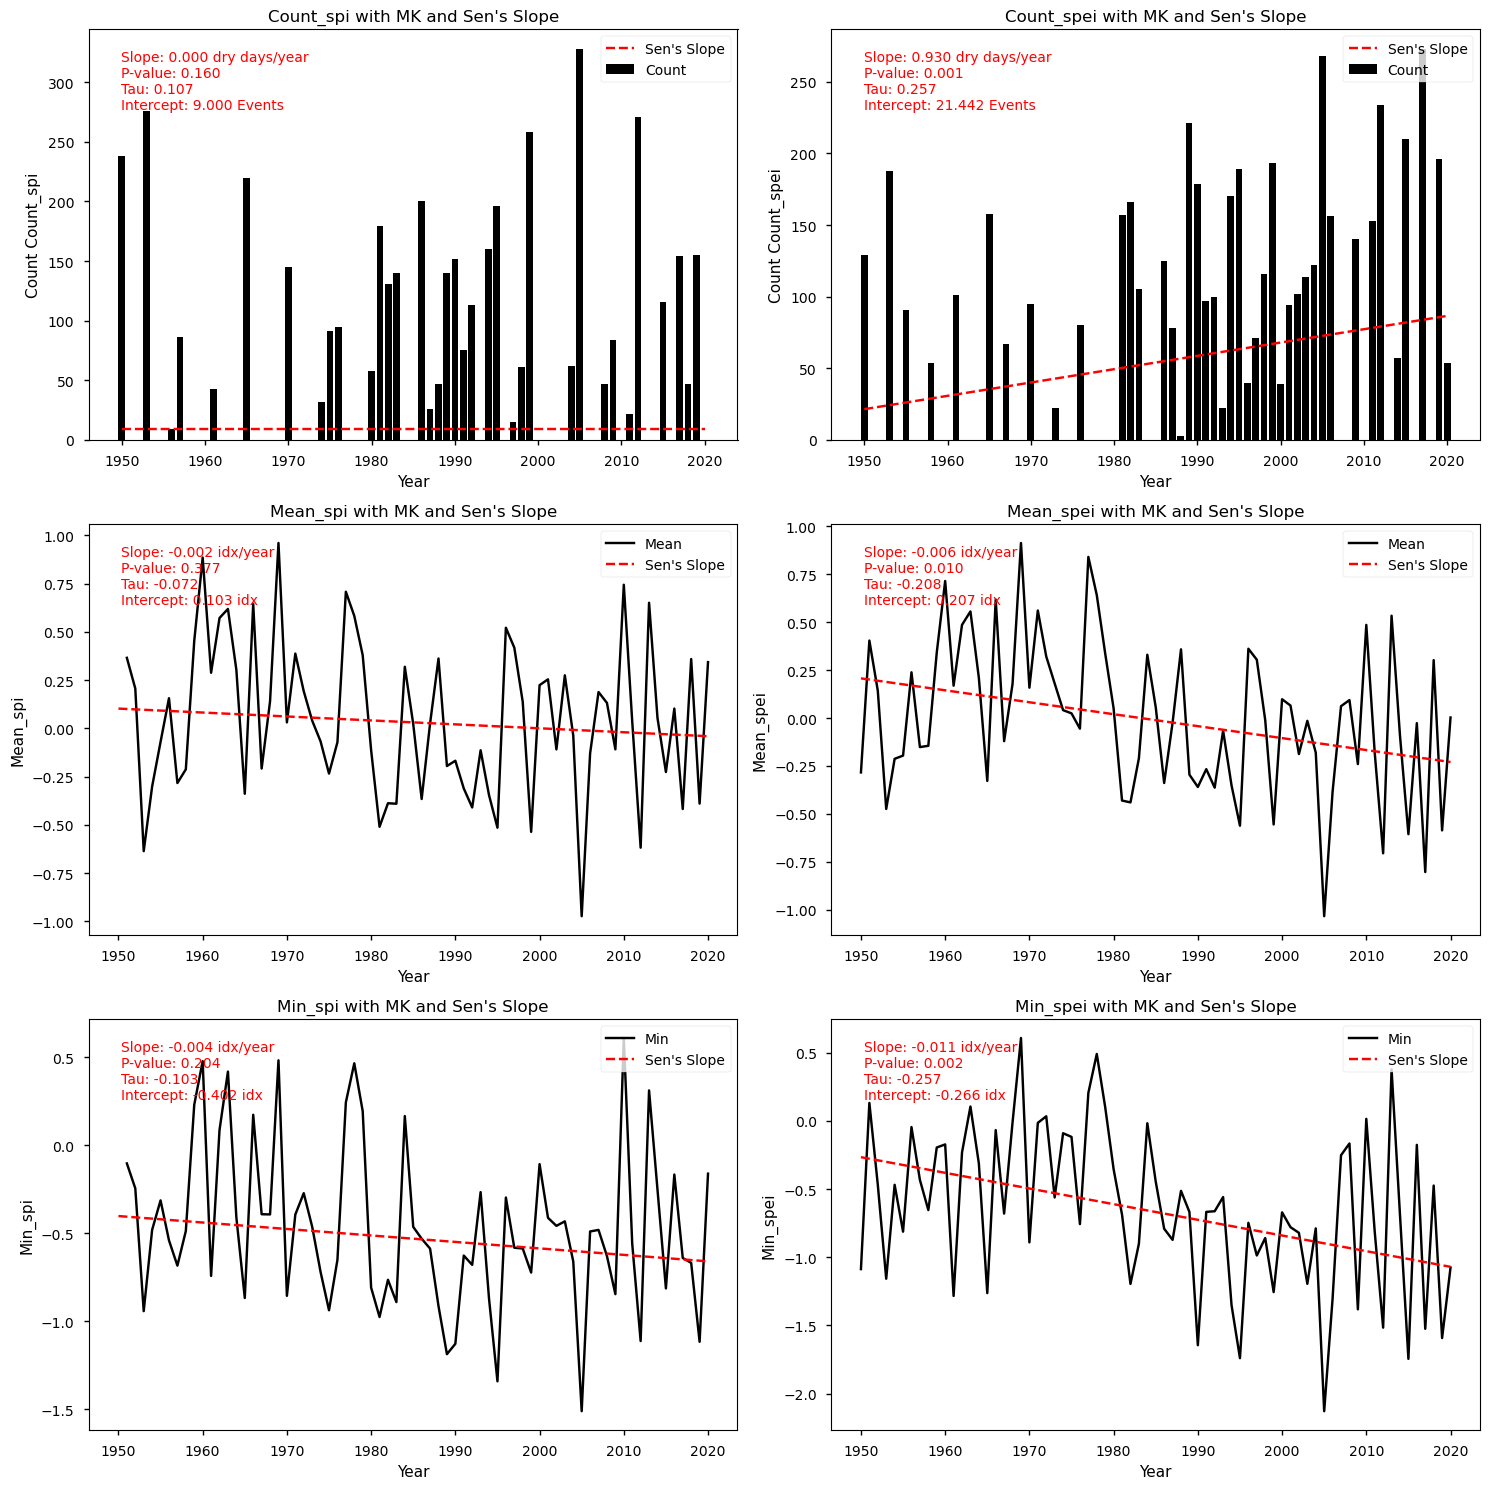

In [69]:
# Plot linear trend of SPI and SPEI
show_mk_sen_results(df_spi_events_stats, df_spei_events_stats, name1='spi', name2='spei', min=True)

From the above plots, we can see that the Mann-Kendall test results indicate that SPEI exhibits significantly more dry events, compared to SPI. Indeed, only SPEI denotes a significant upward trend in the frequency of dry days, with a linear change of 0.93 dry days per year. Likewise, only SPEI shows statistically significant magnitude changes, with SPEI index decreasing by 0.006 (mean) and 0.011 (minimum) per index value per year. Despite non-significant results, SPI also shows lower values and a decreasing Sen's slope estimates. Finally, let's inspect the spatial patterns of these trends to understand which regions show greater drought exposure.

In [70]:
# Helper function to calculate trend and significance
def calculate_trend_and_significance(data_array):
    # Ensure the input array is a DataArray
    if not isinstance(data_array, xr.DataArray):
        raise ValueError("Input must be an xarray DataArray")

    # Rechunk the time dimension to a single chunk
    data_array = data_array.chunk({"time": -1})

    # Get the time dimension name
    time_dim = 'time'

    # Calculate the slope using np.polyfit
    def polyfit_slope(y):
        x = np.arange(len(y))
        return np.polyfit(x, y, 1)[0]

    slope = xr.apply_ufunc(
        polyfit_slope,
        data_array,
        vectorize=True,
        input_core_dims=[[time_dim]],
        dask="parallelized",
        output_dtypes=[float]
    )

    # Apply Mann-Kendall test
    def mann_kendall_p(x):
        return mk.original_test(x).p

    significance = xr.apply_ufunc(
        mann_kendall_p,
        data_array,
        vectorize=True,
        input_core_dims=[[time_dim]],
        dask="parallelized",
        output_dtypes=[float]
    )
    return slope, significance

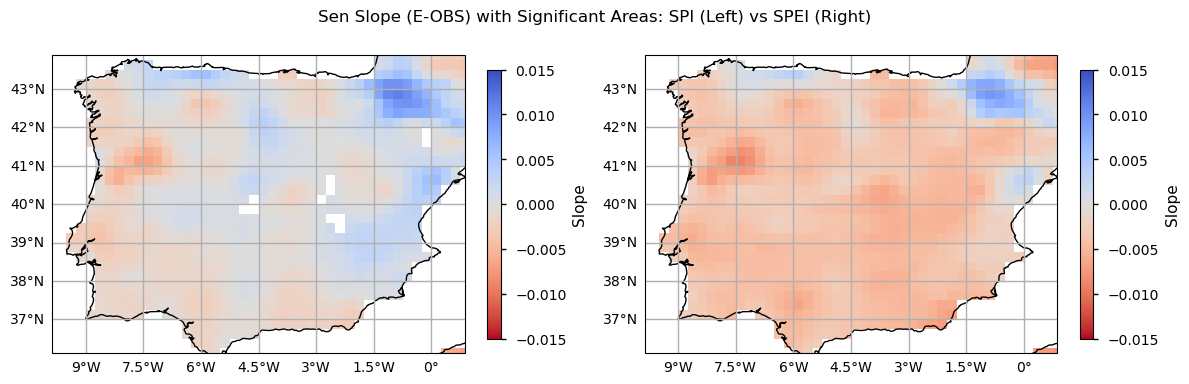

In [74]:
# Calculate the slope and significance per pixel
slope_spi, significance_spi = calculate_trend_and_significance(spi_values_EOBS_compute)
slope_spei, significance_spei = calculate_trend_and_significance(spei_values_EOBS_compute)

# Plot the results
plot_maps(slope_spi.where(slope_spi != 0), slope_spei.where(slope_spei != 0), cmap='coolwarm_r', vmin=-0.015, vmax=0.015, cbar_kwargs={'fraction': 0.03, 'label': 'Slope'})

plt.suptitle('Sen Slope (E-OBS) with Significant Areas: SPI (Left) vs SPEI (Right)', y=0.8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

As with the time series and trend analysis plots, SPEI values are greater, denoting higher sensitivity in detecting drought conditions. While SPI trends have very low magnitudes (thus resulting in non-significant linear changes), the SPEI results indicate a more or less homogenous tendency for drier conditions over the Iberian Peninsula, particularly in the inland northern part of Portugal, and over the south and inland parts of Spain, where evapotranspiration is more significant (see the evapotranspiration plot above). Some exceptions with a positive slope towards wetter conditions (SPEI) are visible in the Pyrenees, Asturias and Valencia regions. Together with the climatology maps and the time series and trend analysis shown before, this results showcase how much the Iberian Peninsula is subject to drought conditions, recently, agreeing with existing literature [[7]](https://doi.org/10.1016/j.wace.2021.100320) and suggesting that the one of the foreseen impacts of climate change over this region are already underway.

--------------------------------------------------------------------------------------------------------------

#### Discussion

The analysis of drought exposure across regions, based on SPI and SPEI indices, provides valuable insights into the changing drought patterns from 1950 to 2020. One of the main findings is that SPEI, which incorporates evapotranspiration, offers a more sensitive depiction of severe drought events compared to SPI, which focuses solely on precipitation. This distinction is particularly important in regions where evapotranspiration significantly impacts water availability.

The use of the Mann-Kendall test and Sen's slope analysis has helped disclose the magnitude of change over this area, and which regions most exposed to droughts. The analysis clearly indicates that the northeast of Portugal is among the regions most affected by an increase in drought frequency and severity, as is the inland and southern parts of Spain. The Sen's slope graphs, which show a more negative trend in SPEI values, support this conclusion, highlighting a more pronounced drying trend in these areas compared to others, even though results are overall homogenous over the Iberian Peninsula.

Contrastingly, some regions, such as the Pyrenees and parts of Asturias and Valencia, show a trend towards wetter conditions over the last 30 years. This suggests that while many regions are becoming drier, there are localized areas that are experiencing increased precipitation and moisture.

The analysis reveals that from 1985 to 2020, there has been a significant increase in moderate to severe drought periods, particularly in the second half of this time frame. The SPI and SPEI plots both show a marked decline in these indices over time, with wetter conditions being more frequent in the earlier years of the study period. This temporal shift in SPI and SPEI values points to a clear intensification of droughts, with dry conditions becoming more common in recent decades. Nevertheless, precipitation shows great interannual variability.

The results of the Mann-Kendall test further reinforce this observation. The upward trend in the frequency of dry events is particularly noticeable in the SPEI dataset, where a positive slope of 0.93 dry days per year reflects the increasing severity of droughts. This trend is particularly pronounced in southern and inland Spain, where high evapotranspiration rates exacerbate the drying conditions.

Overall, the SPEI index derived from E-OBS provides a more sensitive assessment of drought trends, capturing not only the lack of precipitation but also the impact of increasing temperatures and evaporation rates. This makes E-OBS suitable for long-term drought monitoring, particularly in regions where evapotranspiration plays a critical role.

(code-section-6)=  
### 6. Main Takeaways

- The SPEI index, accounting for evapotranspiration, provides a more sensitive depiction of severe droughts compared to SPI, which focuses solely on precipitation, highlighting its importance in regions where evapotranspiration significantly impacts water availability.

- The northeast of Portugal and southern/inland Spain show the highest increase in drought frequency and severity, supported by negative trends in SPEI values. Contrastingly, localized areas like the Pyrenees and parts of Asturias and Valencia indicate wetter trends over the last 30 years.

- From 1985 to 2020, there has been a significant rise in moderate to severe drought periods, with more frequent dry conditions in recent decades. SPI and SPEI plots show wetter conditions in earlier years, transitioning to intensified droughts with marked interannual variability.

- The SPEI index from E-OBS captures both precipitation deficits and the impacts of rising temperatures and evaporation rates, making it more effective for long-term drought monitoring in regions where evapotranspiration is critical.

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:
* E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations:
    https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-europe?tab=overview

* ERA5 hourly data on pressure levels from 1940 to present:
    https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview 

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)


### References:

[[1]](https://climate.copernicus.eu/esotc/2023) Copernicus Climate Change Service. 2024. European State of the Climate 2023.

[[2]](https://climpact-sci.org/) Climpact. 2024.

[[3]](https://library.wmo.int/index.php?lvl=notice_display&id=20130) World Meteorological Organization (WMO) Guidelines on the Calculation of Climate Normals. 

[[4]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017JD028200) Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. (2018). An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. (Atmospheres), 123.

[[5]](https://doi.org/10.1002/joc.7269) Bandhauer, M., Isotta, F., Lakatos, M., Lussana, C., Båserud, L., Izsák, B., Szentes, O., Tveito, O. E., & Frei, C. (2022). Evaluation of daily precipitation analyses in E-OBS (v19.0e) and ERA5 by comparison to regional high-resolution datasets in European regions. International Journal of Climatology, 42(2), 727-747.

[[6]](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.6950) Mavromatis, T. & Voulanas, Dimitrios. (2020). Evaluating ERA‐Interim, Agri4Cast, and E‐OBS gridded products in reproducing spatiotemporal characteristics of precipitation and drought over a data poor region: The Case of Greece. International Journal of Climatology. 41. 

[[7]](https://doi.org/10.1016/j.wace.2021.100320) Páscoa, Patrícia, Russo, Ana, Gouveia, Célia. M., Soares, Pedro M.M., Cardoso, Rita M., Careto, João A.M., Ribeiro, Andreia F.S. (2021). A high-resolution view of the recent drought trends over the Iberian Peninsula. Weather and Climate Extremes, Volume 32, 100320.

[[8]](https://github.com/monocongo/climate_indices) Adams, J. (2017). Climate_indices, an open source Python library providing reference implementations of commonly used climate indices.